In [3]:
!pip install numpy pandas scikit-learn shap scipy kagglehub


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np

from typing import Optional, List
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.preprocessing import StandardScaler


class RobustSparseKMeans(BaseEstimator, ClusterMixin):
    """
    Robust Sparse K-means clustering with outlier detection and feature selection.
    """

    def __init__(
        self,
        n_clusters: int = 8,
        lasso_param: float = 0.1,
        max_iter: int = 100,
        tol: float = 1e-4,
        random_state: Optional[int] = None,
        alpha: float = 0.1,  # Trimming proportion
        scaling: bool = False,
        correlation: bool = False,
    ):
        self.n_clusters = n_clusters
        self.lasso_param = lasso_param
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.alpha = alpha
        self.scaling = scaling
        self.correlation = correlation

        # Attributes for results
        self.n_iter_ = 0
        self.outliers_ = np.array([])
        self.inertia_ = np.inf

    def _identify_outliers(self, distances: np.ndarray) -> np.ndarray:
        """
        Identifies outliers dynamically based on the alpha-trimmed percentile.

        Args:
            distances: Matrix of distances to cluster centers.

        Returns:
            Boolean mask indicating outlier points.
        """
        Nout = int(self.alpha * len(distances))
        if Nout == 0:
            return np.zeros(len(distances), dtype=bool)

        sorted_distances = np.sort(np.min(distances, axis=1))
        threshold = sorted_distances[-Nout]
        return np.min(distances, axis=1) > threshold

    def fit(self, X: np.ndarray, feature_names: List[str]) -> "RobustSparseKMeans":
        """
        Fit Robust Sparse K-means with outlier detection and feature selection.

        Args:
            X: Input data.
            feature_names: Names of features for reference.
        """

        if self.random_state is not None:
            np.random.seed(self.random_state)

        n_samples, n_features = X.shape

        # Data standardization
        self.scaler_ = StandardScaler()
        X = self.scaler_.fit_transform(X) if self.scaling else X

        # Normalize by rows if correlation-based scaling is enabled
        if self.correlation:
            X = StandardScaler().fit_transform(X.T).T

        # Initialize centers and weights
        centers = self._init_centers(X)
        weights = np.ones(n_features) / np.sqrt(n_features)

        # Outlier mask initialization
        outlier_mask = np.zeros(n_samples, dtype=bool)

        old_inertia = float("inf")

        for iteration in range(self.max_iter):
            distances = np.zeros((n_samples, self.n_clusters))
            for k in range(self.n_clusters):
                diff = X - centers[k]
                distances[:, k] = np.sum(weights * diff**2, axis=1)

            # Assign clusters
            labels = np.argmin(distances, axis=1)

            # Update outlier identification
            outlier_mask = self._identify_outliers(distances)

            # Update weights and centers using only non-outlier points
            non_outlier_mask = ~outlier_mask
            if np.any(non_outlier_mask):
                weights = self._update_weights(X[non_outlier_mask], centers, labels[non_outlier_mask])
                centers = self._update_centers(X[non_outlier_mask], labels[non_outlier_mask], weights)

            # Calculate inertia
            inertia = 0
            for k in range(self.n_clusters):
                mask = (labels == k) & ~outlier_mask
                if np.any(mask):
                    diff = X[mask] - centers[k]
                    inertia += np.sum(weights * np.sum(diff**2, axis=0))

            # Check convergence
            if abs(old_inertia - inertia) < self.tol:
                break

            old_inertia = inertia
            self.n_iter_ += 1

        # Store results
        self.cluster_centers_ = self.scaler_.inverse_transform(centers) if self.scaling else centers
        self.labels_ = labels
        self.weights_ = weights
        self.sorted_weights_ = np.sort(weights)
        self.inertia_ = inertia
        self.outliers_ = np.where(outlier_mask)[0]

        # Store feature importance
        self.feature_importance_ = dict(zip(feature_names, weights))
        self.selected_features_ = [name for name, weight in self.feature_importance_.items() if weight > 1e-4]

        return self

    def _init_centers(self, X: np.ndarray) -> np.ndarray:
        """
        Initialize cluster centers using K-means++ with improved sampling.
        """
        n_samples = X.shape[0]  # Get the number of rows in the subset DataFrame
        centers = np.zeros((self.n_clusters, X.shape[1]))

        first_center_idx = np.random.randint(n_samples)  # Generate index within the bounds of the subset DataFrame
        centers[0] = X[first_center_idx]  # Access the data using array indexing

        for i in range(1, self.n_clusters):
            min_distances = np.min([np.sum((X - center) ** 2, axis=1) for center in centers[:i]], axis=0)
            probabilities = min_distances / min_distances.sum()
            next_center_idx = np.random.choice(n_samples, p=probabilities)  # Generate index within the bounds of the subset DataFrame
            centers[i] = X[next_center_idx]  # Access the data using array indexing

        return centers

    def _update_weights(self, X: np.ndarray, centers: np.ndarray, labels: np.ndarray) -> np.ndarray:
        """
        Update feature weights using proper L1-regularized optimization.

        Returns:
            Updated feature weights.
        """
        n_features = X.shape[1]
        bcss = np.zeros(n_features)
        global_mean = np.mean(X, axis=0)

        for k in range(self.n_clusters):
            mask = labels == k
            if np.any(mask):
                cluster_mean = np.mean(X[mask], axis=0)
                n_points = np.sum(mask)
                bcss += n_points * (cluster_mean - global_mean) ** 2

        # Apply soft thresholding and normalize
        weights = np.maximum(0, bcss - self.lasso_param)
        weights = weights * np.sqrt(len(weights)) / np.linalg.norm(weights)

        return weights

    def _update_centers(self, X: np.ndarray, labels: np.ndarray, weights: np.ndarray) -> np.ndarray:
        """
        Update cluster centers using weighted mean.

        Returns:
            Updated cluster centers.
        """
        n_features = X.shape[1]
        centers = np.zeros((self.n_clusters, n_features))
        X_weighted = X * weights[np.newaxis, :]

        global_mean = np.mean(X_weighted, axis=0)

        for k in range(self.n_clusters):
            mask = labels == k
            centers[k] = np.mean(X_weighted[mask], axis=0) if np.any(mask) else global_mean

        return centers

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict cluster labels for new data.
        """
        distances = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            diff = X - self.cluster_centers_[k]
            distances[:, k] = np.sum(self.weights_ * diff**2, axis=1)
        return np.argmin(distances, axis=1)


### Pre Processing Data

In [4]:
import pandas as pd
# dataset = pd.read_csv('/root/.cache/kagglehub/datasets/yogidsba/us-highway-railgrade-crossing-accident/versions/1/Highway-Rail_Grade_Crossing_Accident_Data.csv', low_memory=False, sep=',')
dataset = pd.read_csv('datasets/Highway-Rail_Grade_Crossing_Accident_Data.csv', low_memory=False, sep=',')

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Seu código existente
features = [
    'Crossing Users Killed For Reporting Railroad',
    'Crossing Users Injured For Reporting Railroad',
    'Employees Killed For Reporting Railroad',
    'Employees Injured For Reporting Railroad',
    'Passengers Killed For Reporting Railroad',
    'Passengers Injured For Reporting Railroad',
    'Total Killed Form 57',
    'Total Injured Form 57',
    'Total Killed Form 55A',
    'Total Injured Form 55A',
    'Vehicle Damage Cost',
    'View Obstruction Code',
    # 'Signaled Crossing Warning Code',
    # 'Warning Connected To Signal',
    # 'Crossing Illuminated',
    # Condições Ambientais
    # 'Roadway Condition Code',
    'Weather Condition Code',
    'Visibility Code',
    'Train Speed'
]

In [10]:
dataset[features].head()

,Crossing Users Killed For Reporting Railroad,Crossing Users Injured For Reporting Railroad,Employees Killed For Reporting Railroad,Employees Injured For Reporting Railroad,Passengers Killed For Reporting Railroad,Passengers Injured For Reporting Railroad,Total Killed Form 57,Total Injured Form 57,Total Killed Form 55A,Total Injured Form 55A,Vehicle Damage Cost,View Obstruction Code,Signaled Crossing Warning Code,Weather Condition Code,Visibility Code,Train Speed
0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,1,2000.0,8.0,1,4.0,2.0,55.0
1,1.0,6.0,0.0,0.0,0.0,0.0,1,6,1,6,5000.0,8.0,1,1.0,4.0,59.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,800.0,8.0,1,1.0,3.0,5.0
3,0.0,2.0,0.0,0.0,0.0,0.0,0,2,0,2,1200.0,8.0,1,4.0,2.0,31.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,1,2000.0,8.0,1,1.0,2.0,70.0


In [11]:
dataset[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239487 entries, 0 to 239486
Data columns (total 16 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   Crossing Users Killed For Reporting Railroad   237239 non-null  float64
 1   Crossing Users Injured For Reporting Railroad  237643 non-null  float64
 2   Employees Killed For Reporting Railroad        236971 non-null  float64
 3   Employees Injured For Reporting Railroad       237044 non-null  float64
 4   Passengers Killed For Reporting Railroad       233401 non-null  float64
 5   Passengers Injured For Reporting Railroad      233343 non-null  float64
 6   Total Killed Form 57                           239487 non-null  int64  
 7   Total Injured Form 57                          239487 non-null  int64  
 8   Total Killed Form 55A                          239487 non-null  int64  
 9   Total Injured Form 55A               

In [15]:
dataset[features].apply(lambda x: x.unique())

Crossing Users Killed For Reporting Railroad     [0.0, 1.0, nan, 2.0, 4.0, 6.0, 3.0, 5.0, 7.0, ...
Crossing Users Injured For Reporting Railroad    [1.0, 6.0, 0.0, 2.0, nan, 3.0, 4.0, 5.0, 8.0, ...
Employees Killed For Reporting Railroad                                  [0.0, nan, 1.0, 2.0, 3.0]
Employees Injured For Reporting Railroad         [0.0, nan, 1.0, 3.0, 2.0, 7.0, 6.0, 4.0, 5.0, ...
Passengers Killed For Reporting Railroad                           [0.0, nan, 11.0, 1.0, 4.0, 5.0]
Passengers Injured For Reporting Railroad        [0.0, nan, 9.0, 3.0, 2.0, 26.0, 8.0, 16.0, 1.0...
Total Killed Form 57                             [0, 1, 2, 4, 6, 3, 5, 7, 60, 10, 9, 8, 11, 20,...
Total Injured Form 57                            [1, 6, 0, 2, 10, 3, 4, 33, 18, 23, 22, 57, 5, ...
Total Killed Form 55A                                   [0, 1, 2, 4, 6, 3, 5, 7, 10, 9, 8, 11, 12]
Total Injured Form 55A                           [1, 6, 0, 2, 10, 3, 4, 33, 18, 23, 22, 57, 5, ...
Vehicle Da

In [18]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

X = dataset[features]
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(X.select_dtypes(include=['float64', 'int64'])))
df_imputed.columns = X.select_dtypes(include=['float64', 'int64']).columns

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_imputed)

In [21]:
X_scaled

array([[-0.26911636,  0.9343431 , -0.01757155, ...,  2.29184075,
        -0.73384585,  1.69604196],
       [ 2.44742184,  7.99106563, -0.01757155, ..., -0.54516022,
         1.28968328,  1.91713258],
       [-0.26911636, -0.47700141, -0.01757155, ..., -0.54516022,
         0.27791872, -1.06759077],
       ...,
       [-0.26911636, -0.47700141, -0.01757155, ..., -0.54516022,
        -0.73384585, -0.79122749],
       [ 2.44742184, -0.47700141, -0.01757155, ..., -0.54516022,
         1.28968328,  1.14331541],
       [-0.26911636, -0.47700141, -0.01757155, ...,  0.40050677,
         1.28968328, -0.79122749]])

In [23]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
kmeans.fit(X_scaled)
predicted_labels_kmeans = kmeans.labels_

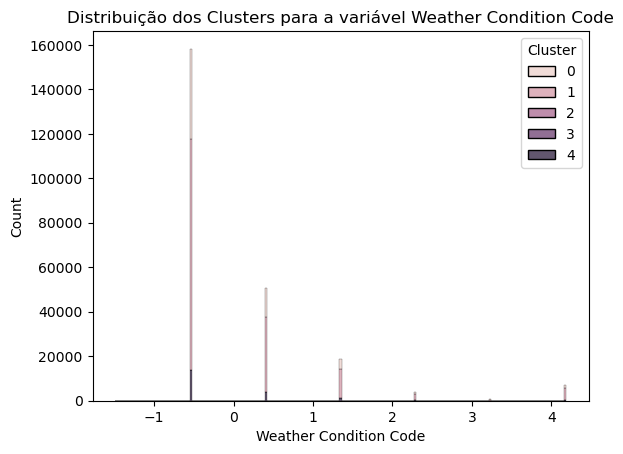

In [28]:
# Converter X_scaled para um DataFrame do Pandas
X_scaled_df = pd.DataFrame(X_scaled, columns=X.select_dtypes(include=['float64', 'int64']).columns)

# Adicionar a coluna 'Cluster'
X_scaled_df['Cluster'] = predicted_labels_kmeans

sns.histplot(data=X_scaled_df, x='Weather Condition Code', hue='Cluster', multiple="stack")
plt.title('Distribuição dos Clusters para a variável Weather Condition Code')
plt.show()

ValueError: Could not interpret value `Signaled Crossing Warning Code` for `x`. An entry with this name does not appear in `data`.

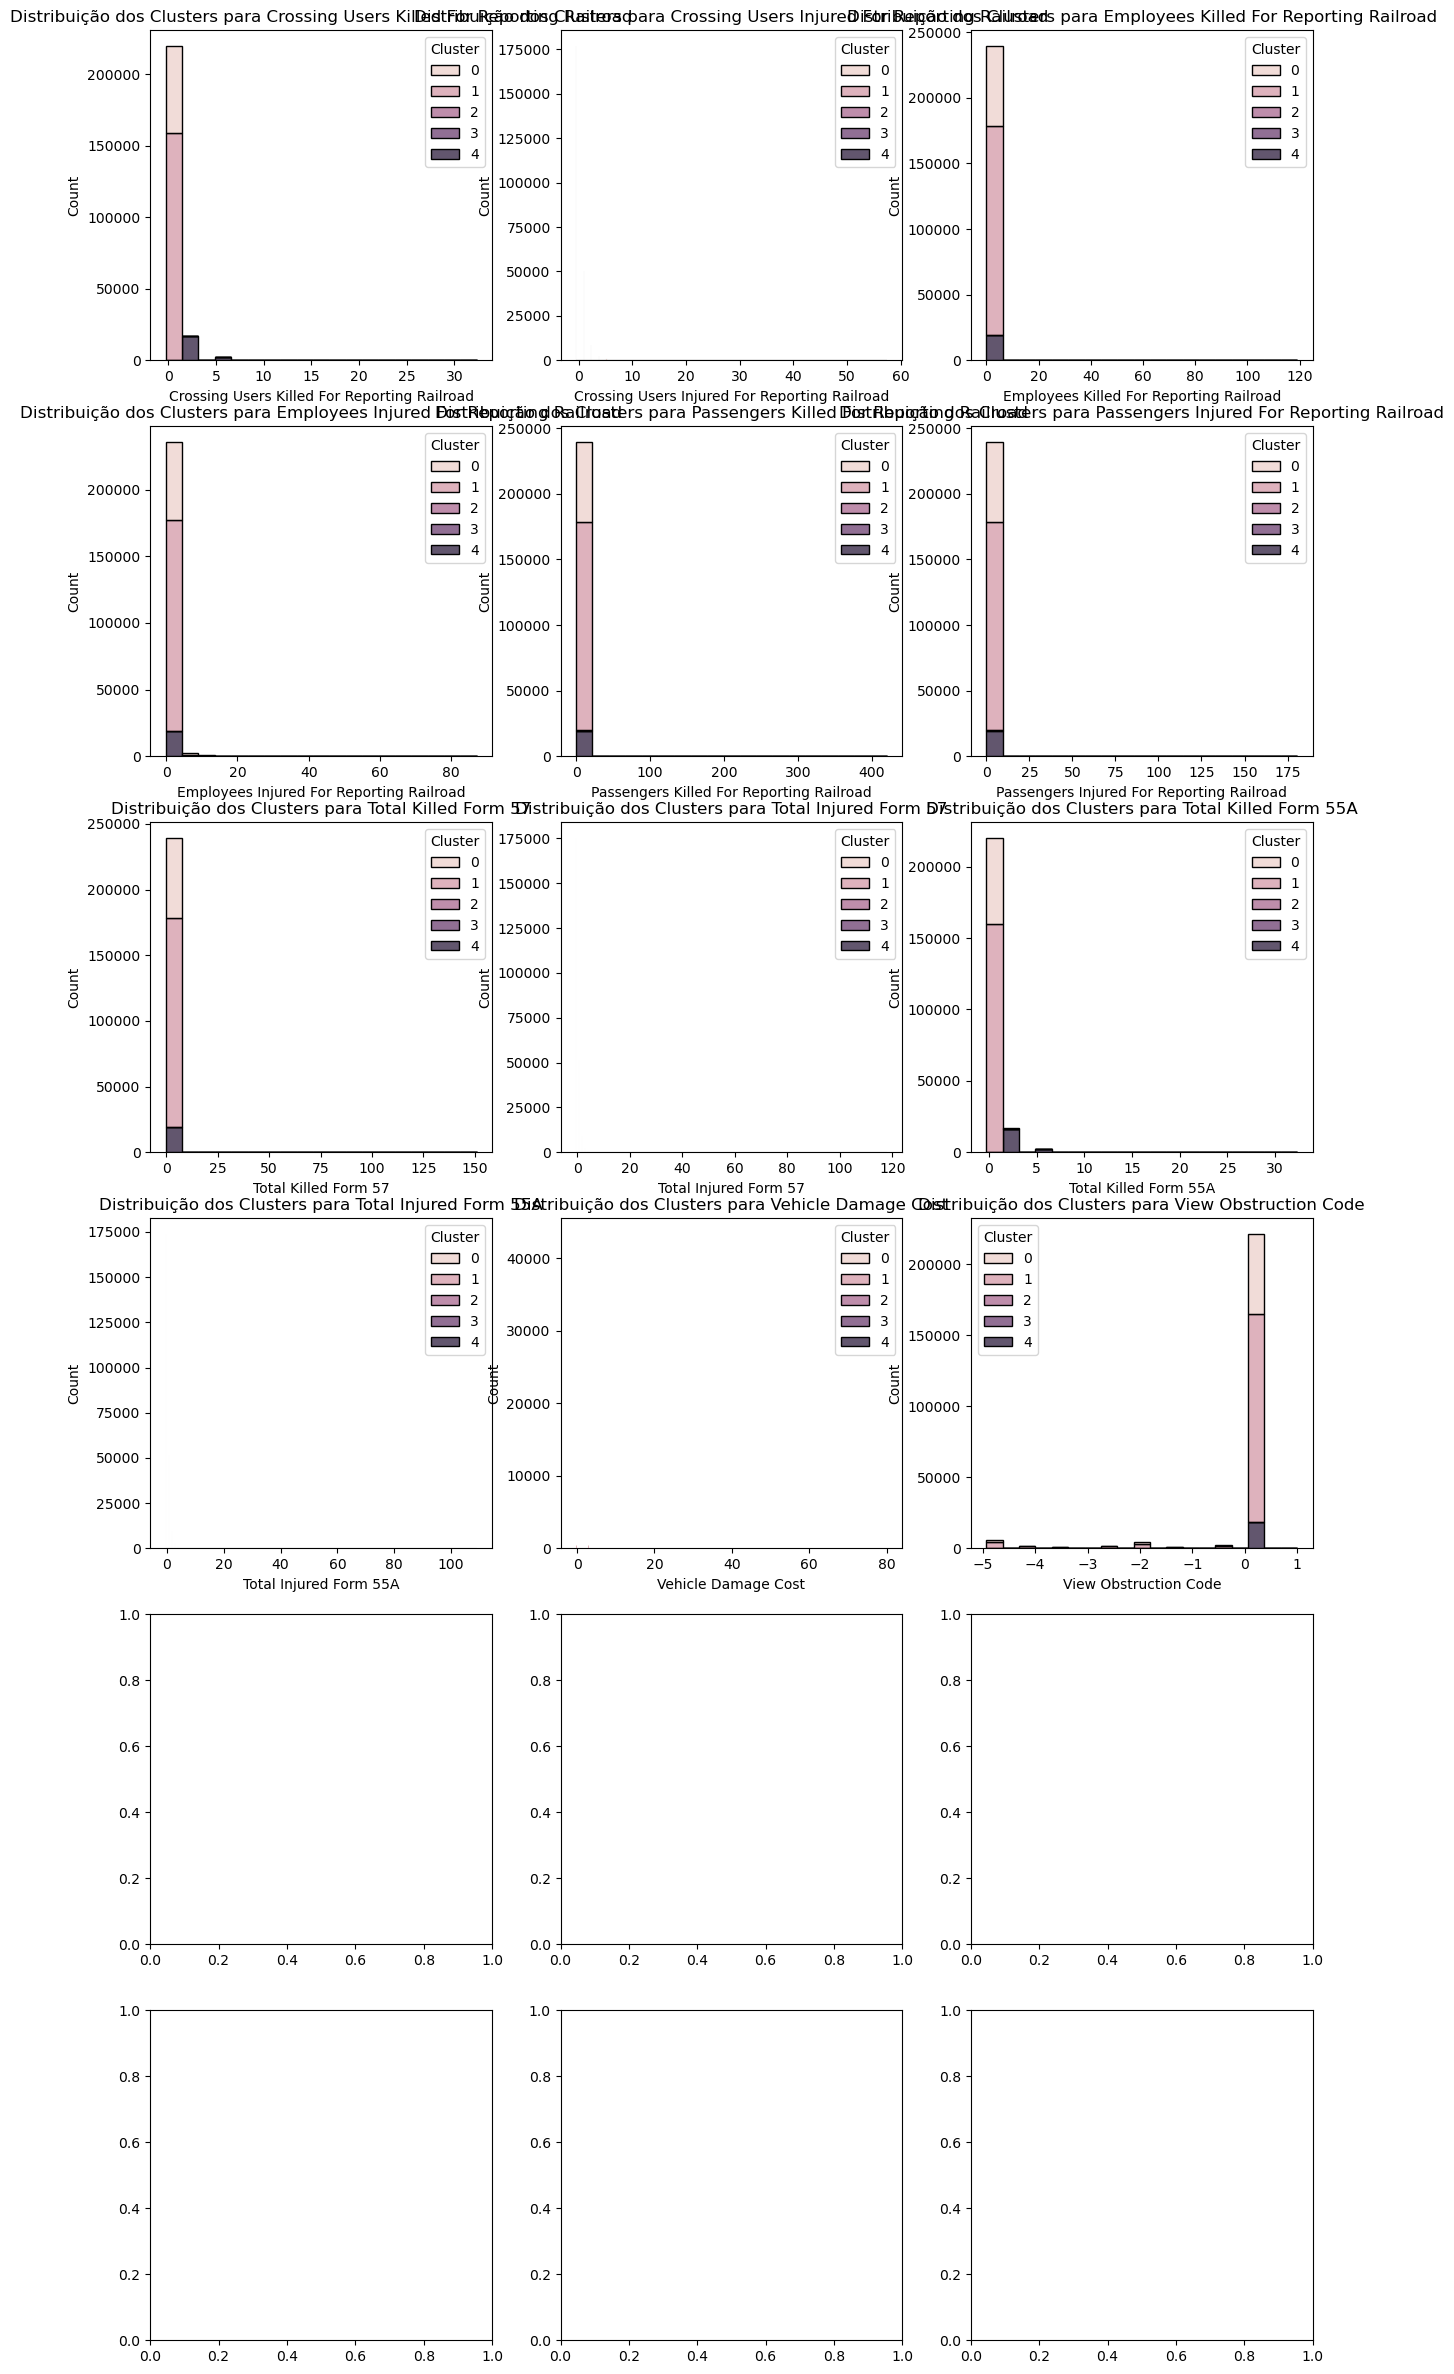

In [29]:
# Número de subgráficos que serão criados
n = len(features)
n_rows = (n // 3) + (n % 3 > 0)  # Organize em 3 colunas (ajuste conforme necessário)
n_cols = 3

# Criar os subgráficos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Para facilitar a iteração

for i, var in enumerate(features):
    sns.histplot(data=X_scaled_df, x=var, hue='Cluster', multiple="stack", ax=axes[i])
    axes[i].set_title(f'Distribuição dos Clusters para {var}')

# Ajustar layout
plt.tight_layout()
plt.show()

In [31]:
valid_features = [feature for feature in features if feature in X_scaled_df.columns]
print("Variáveis válidas para plotagem:", valid_features)

Variáveis válidas para plotagem: ['Crossing Users Killed For Reporting Railroad', 'Crossing Users Injured For Reporting Railroad', 'Employees Killed For Reporting Railroad', 'Employees Injured For Reporting Railroad', 'Passengers Killed For Reporting Railroad', 'Passengers Injured For Reporting Railroad', 'Total Killed Form 57', 'Total Injured Form 57', 'Total Killed Form 55A', 'Total Injured Form 55A', 'Vehicle Damage Cost', 'View Obstruction Code', 'Weather Condition Code', 'Visibility Code', 'Train Speed']


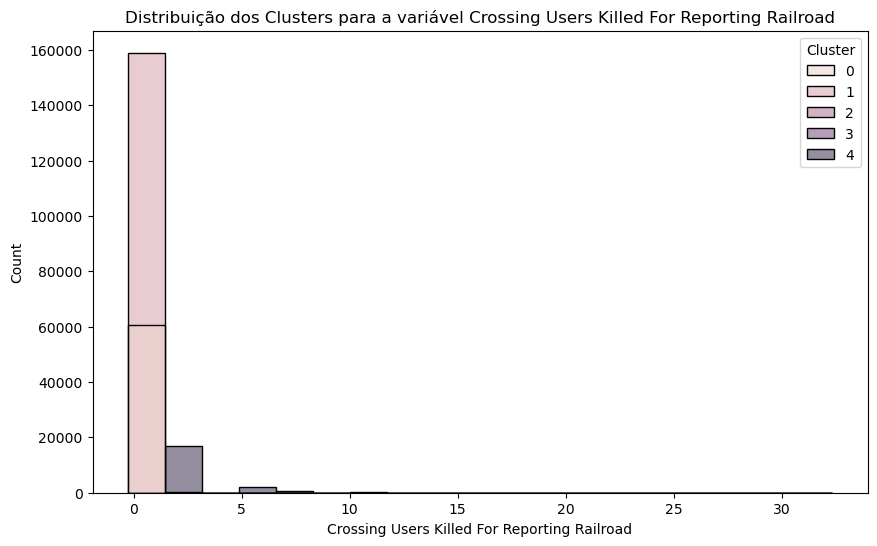

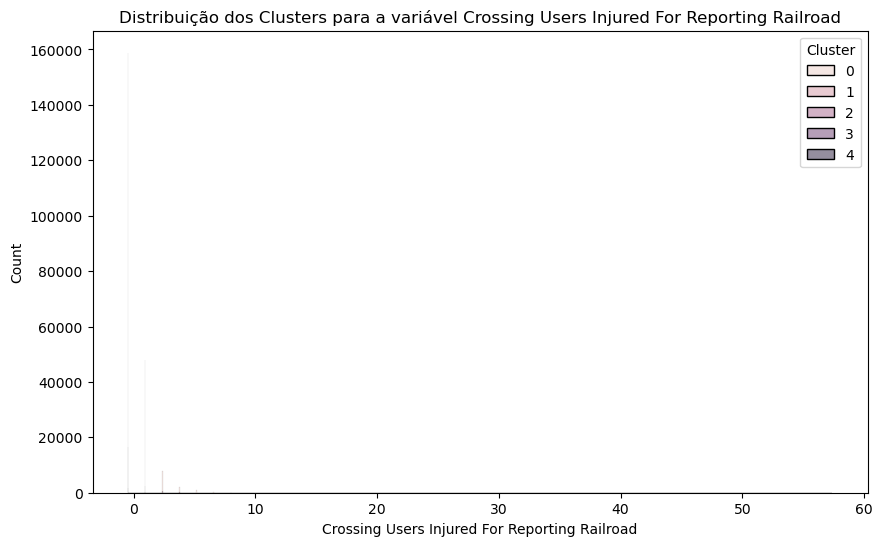

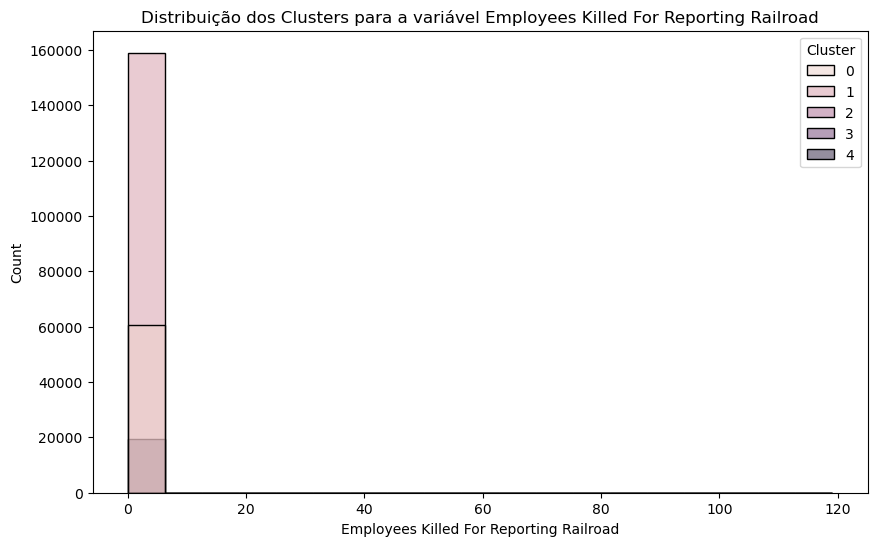

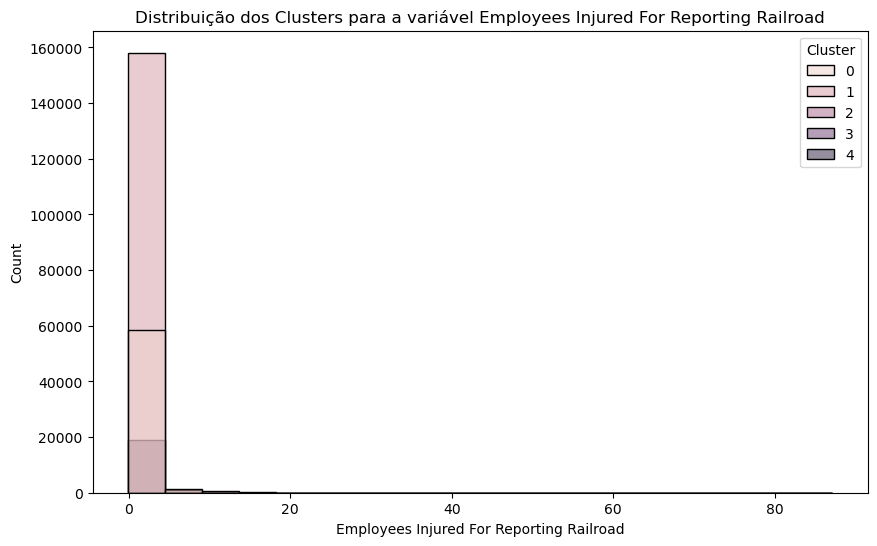

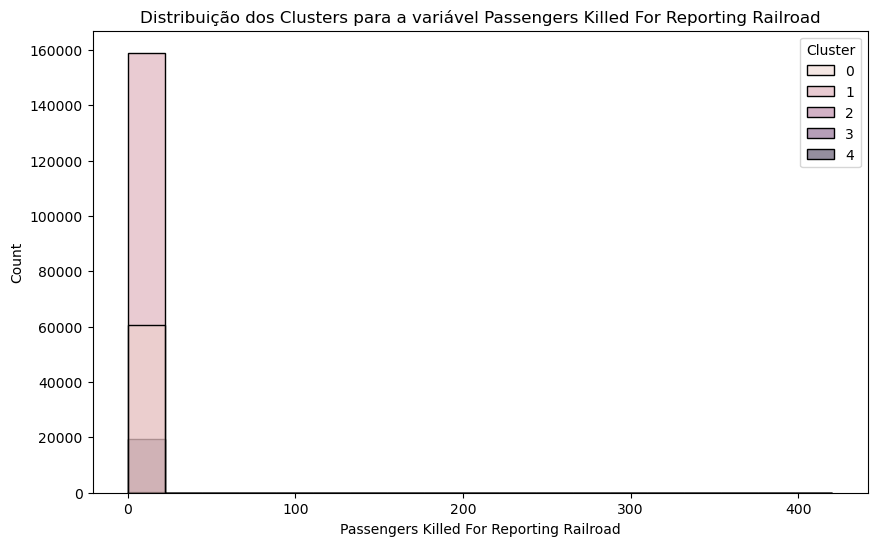

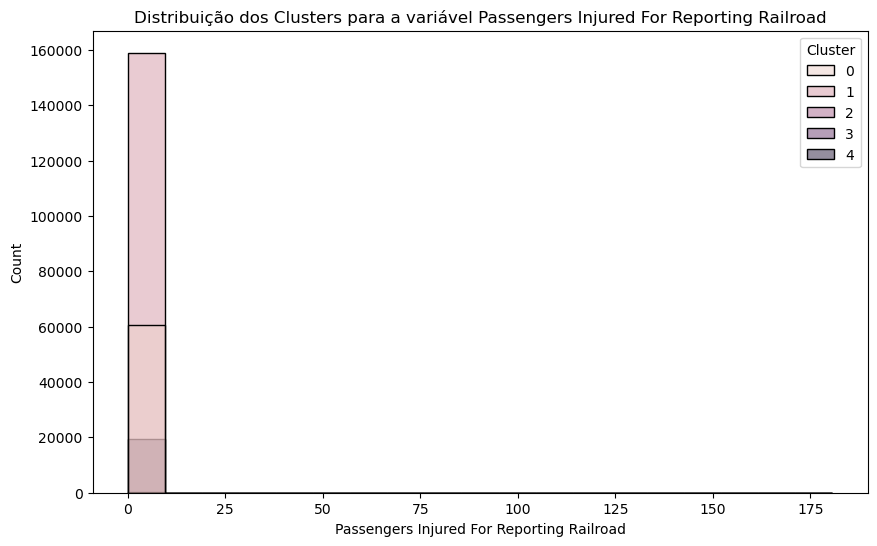

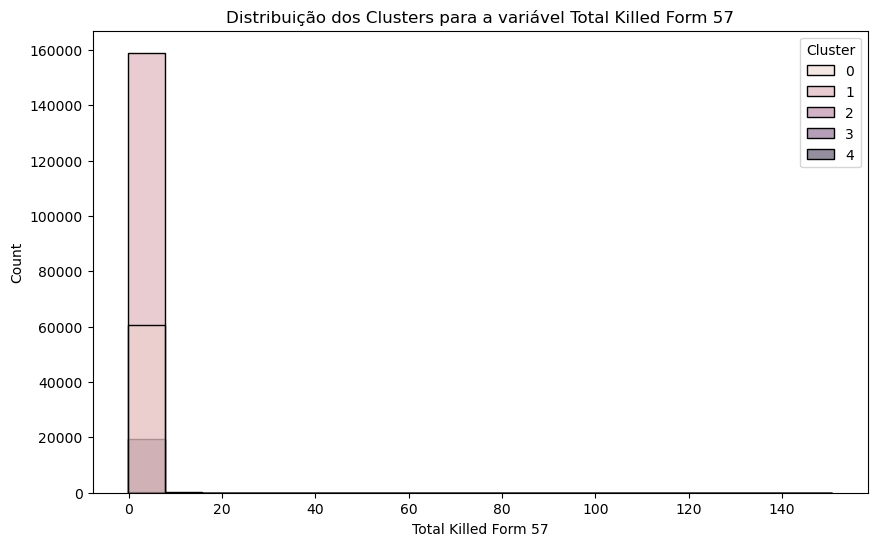

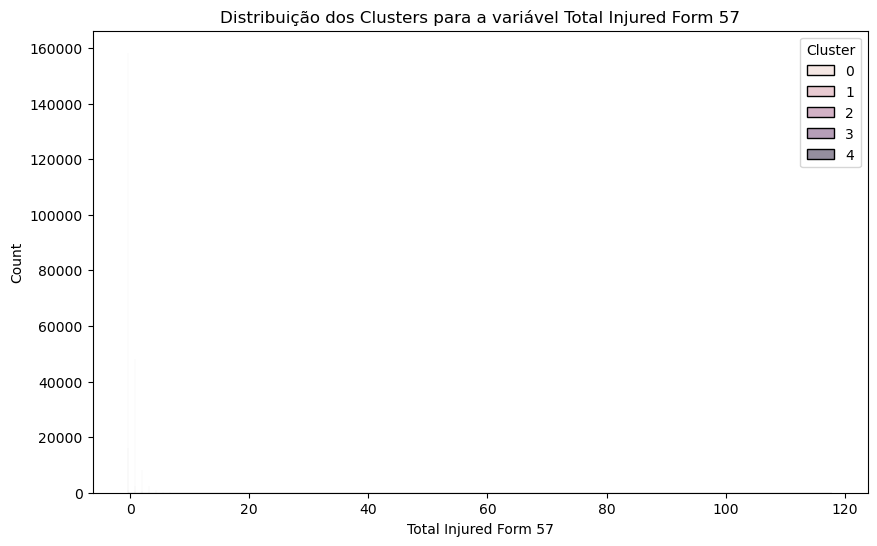

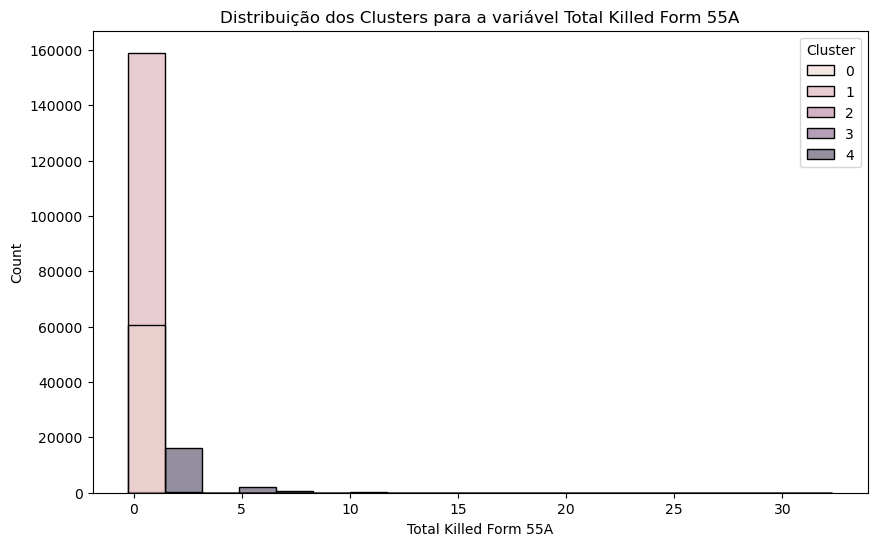

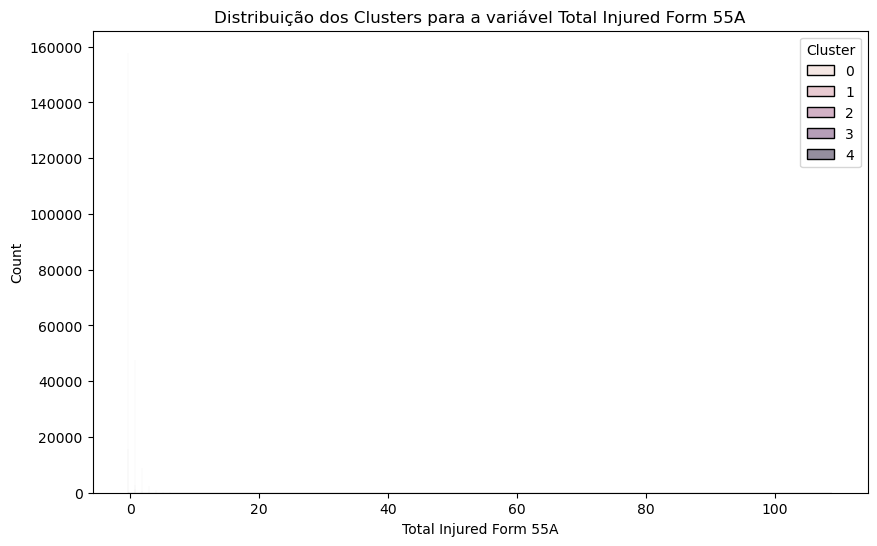

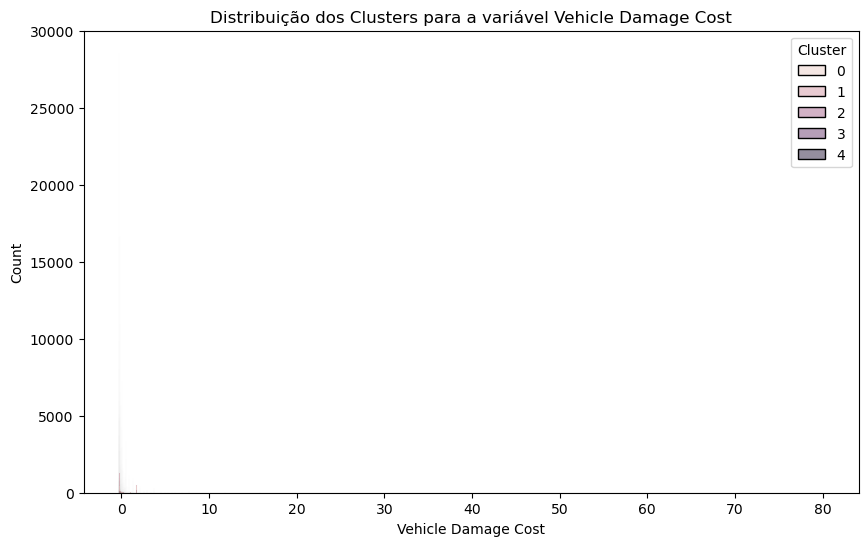

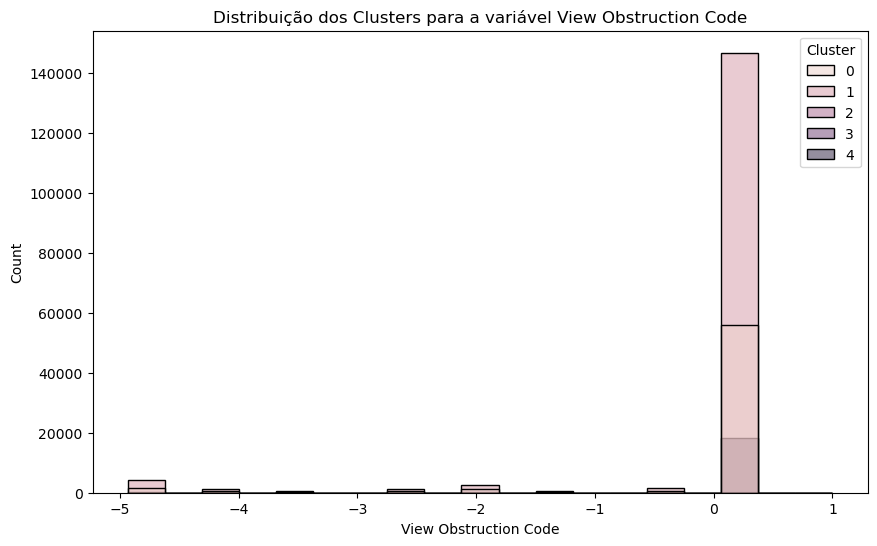

A variável 'Signaled Crossing Warning Code' não está presente no DataFrame.


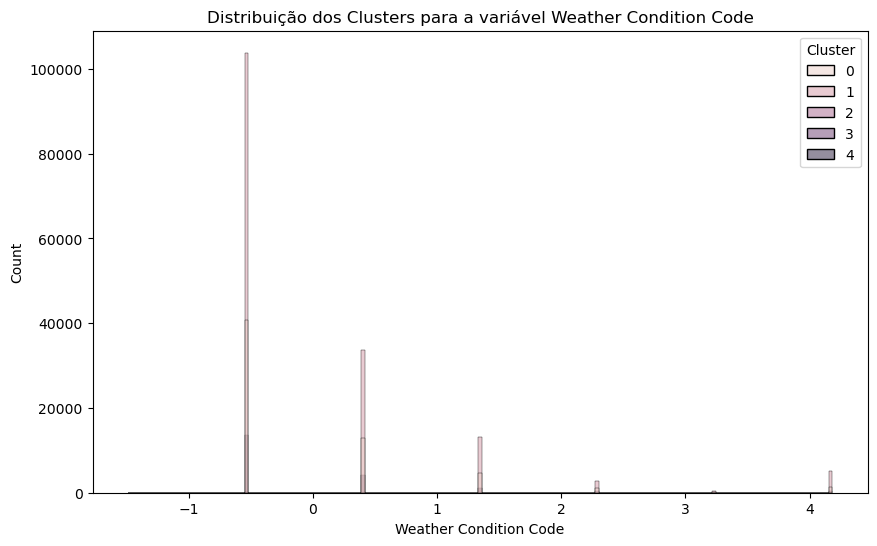

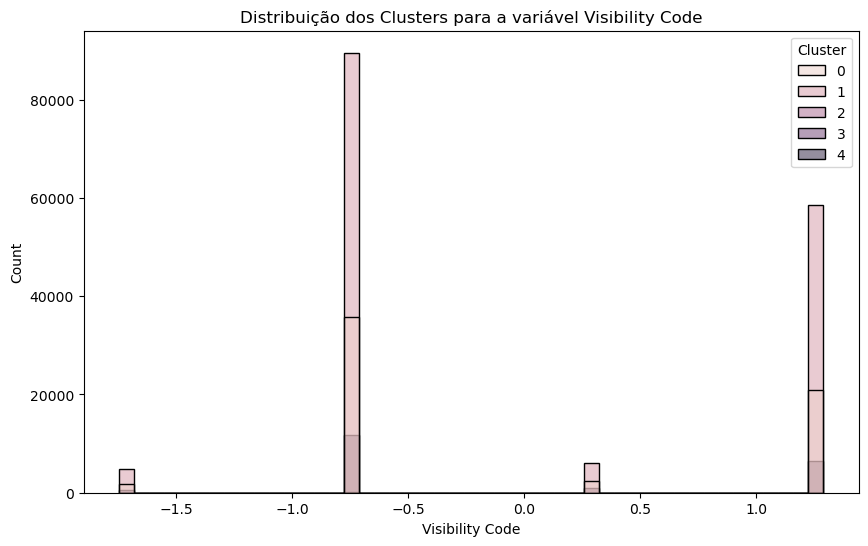

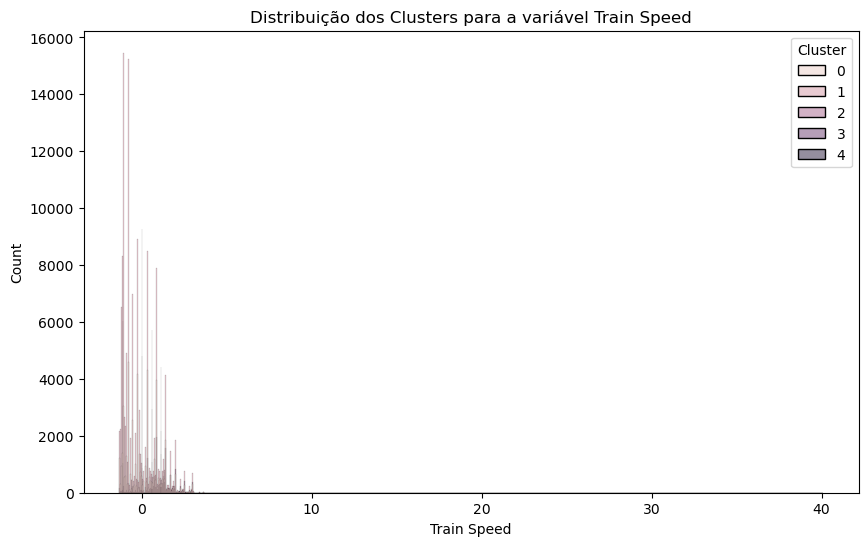

In [36]:
for var in features:
    if var in X_scaled_df.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(data=X_scaled_df, x=var, hue='Cluster', multiple="layer")
        plt.title(f'Distribuição dos Clusters para a variável {var}')
        plt.show()
    else:
        print(f"A variável '{var}' não está presente no DataFrame.")